## Mixed-element Meshing - Toy Problem

This workflow provides a testbed for testing features of mixed-element mesh wotkflow. The objects of river tree and huc boundary are a created to mimic what we get from NHDPlus. This example tests the case of two rivers, which is rare but still needs to be considered to make the workflow general

In [1]:
%matplotlib ipympl

In [2]:
## Importing all the package needed to run the workflow

import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import copy
import geopandas as gpd

In [3]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.resampling
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)
crs = None

In [4]:
## NHDPlus input type objects

# creating watershed polygon
ws1 = shapely.geometry.Polygon(100*np.array([[0,0],[1,0],[2,0],[3,0],[4,0],[4,1],[4,2],[4,3],[4,4],[3,4.5],[2,5],[1,4.5], [0,4], [0,3], [0,2] ,[0,1]], 'd'))
my_hucs = gpd.GeoDataFrame()
my_hucs['geometry'] = [ws1,]

# creating reaches miminc NHDPlus flowlines
reach1=shapely.geometry.LineString([(200,200),(200,0)])
reach2=shapely.geometry.LineString([ (50,300), (100,300), (100,200),(200,200)])
reach3=shapely.geometry.LineString([ (350,400),(350,300),(300,300),(300,200),(200,200)])
reach4=shapely.geometry.LineString([(100,400), (200,300)])
reaches = gpd.GeoDataFrame()
reaches.geometry = [reach1, reach2, reach3, reach4]

In [5]:
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]

In [6]:
# creating watershed_workflow.split_hucs.SplitHUCs object for demo watershed
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2024-12-13 17:55:22,543 - root - INFO: Removing holes on 1 polygons
2024-12-13 17:55:22,543 - root - INFO:   -- removed interior
2024-12-13 17:55:22,543 - root - INFO:   -- union
2024-12-13 17:55:22,544 - root - INFO: Parsing 1 components for holes
2024-12-13 17:55:22,544 - root - INFO:   -- complete


In [7]:
rivers = watershed_workflow.river_tree.createRivers(reaches, method='geometry')

In [8]:
# copy the originals
watershed_orig, rivers_orig = watershed, rivers

In [9]:
# simplify the geometry for a "nicer" discrete object, using a uniform sampling strategy
watershed1, rivers1 = createCopy(watershed_orig, rivers_orig)
watershed_workflow.simplify(watershed1, rivers1, 10, keep_points=True)

2024-12-13 17:55:22,553 - root - INFO: 
2024-12-13 17:55:22,553 - root - INFO: Simplifying
2024-12-13 17:55:22,553 - root - INFO: ------------------------------
2024-12-13 17:55:22,554 - root - INFO: Presimplify to remove colinear, coincident points.
2024-12-13 17:55:22,554 - root - INFO: Pruning leaf reaches < 10
2024-12-13 17:55:22,554 - root - INFO: Merging internal reaches < 10
2024-12-13 17:55:22,555 - root - INFO:   reach: min seg length: 	   50.0000000000 	min geom length: 	  141.4213562373
2024-12-13 17:55:22,555 - root - INFO:   reach: med seg length: 	  100.0000000000 	med geom length: 	  225.0000000000
2024-12-13 17:55:22,556 - root - INFO:   reach: max seg length: 	  200.0000000000 	max geom length: 	  350.0000000000
2024-12-13 17:55:22,556 - root - INFO: 
2024-12-13 17:55:22,557 - root - INFO:   HUC  : min seg length: 	  223.6067977500 	min geom length: 	 1647.2135955000
2024-12-13 17:55:22,557 - root - INFO:   HUC  : med seg length: 	  400.0000000000 	med geom length: 	 1

In [10]:
# simplify the geometry using a distance-function based resampling
watershed2, rivers2 = createCopy(watershed_orig, rivers_orig)
watershed_workflow.simplify(watershed2, rivers2, 10, 50, 50, 150, keep_points=True)

2024-12-13 17:55:22,602 - root - INFO: 
2024-12-13 17:55:22,603 - root - INFO: Simplifying
2024-12-13 17:55:22,603 - root - INFO: ------------------------------
2024-12-13 17:55:22,604 - root - INFO: Presimplify to remove colinear, coincident points.
2024-12-13 17:55:22,605 - root - INFO: Pruning leaf reaches < 10
2024-12-13 17:55:22,606 - root - INFO: Merging internal reaches < 10
2024-12-13 17:55:22,606 - root - INFO:   reach: min seg length: 	   50.0000000000 	min geom length: 	  141.4213562373
2024-12-13 17:55:22,607 - root - INFO:   reach: med seg length: 	  100.0000000000 	med geom length: 	  225.0000000000
2024-12-13 17:55:22,607 - root - INFO:   reach: max seg length: 	  200.0000000000 	max geom length: 	  350.0000000000
2024-12-13 17:55:22,607 - root - INFO: 
2024-12-13 17:55:22,608 - root - INFO:   HUC  : min seg length: 	  223.6067977500 	min geom length: 	 1647.2135955000
2024-12-13 17:55:22,608 - root - INFO:   HUC  : med seg length: 	  400.0000000000 	med geom length: 	 1

Text(0.5, 1.0, 'dist-based resampling')

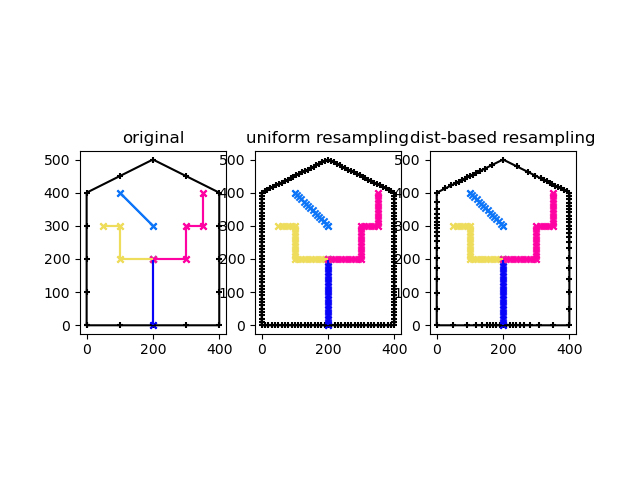

In [11]:
# plot the results
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=20, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=20, ax=ax)

fig, axs = plt.subplots(1,3)
plot(watershed_orig, rivers_orig, axs[0])
axs[0].set_title('original')

plot(watershed1, rivers1, axs[1])
axs[1].set_title('uniform resampling')

plot(watershed2, rivers2, axs[2])
axs[2].set_title('dist-based resampling')


# Meshing

2024-12-13 17:55:22,925 - root - INFO: 
2024-12-13 17:55:22,926 - root - INFO: Stream-aligned Meshing
2024-12-13 17:55:22,927 - root - INFO: ------------------------------
2024-12-13 17:55:22,927 - root - INFO: Creating stream-aligned mesh...
2024-12-13 17:55:22,948 - root - INFO: 
2024-12-13 17:55:22,948 - root - INFO: Triangulation
2024-12-13 17:55:22,948 - root - INFO: ------------------------------
2024-12-13 17:55:22,954 - root - INFO: Triangulating...
2024-12-13 17:55:22,955 - root - INFO:    277 points and 278 facets
2024-12-13 17:55:22,955 - root - INFO:  checking graph consistency
2024-12-13 17:55:22,955 - root - INFO:  tolerance is set to 0.1
2024-12-13 17:55:22,957 - root - INFO:  building graph data structures
2024-12-13 17:55:22,958 - root - INFO:  triangle.build...
2024-12-13 17:55:23,114 - root - INFO:   ...built: 872 mesh points and 1467 triangles
2024-12-13 17:55:23,114 - root - INFO: Plotting triangulation diagnostics
2024-12-13 17:55:23,157 - root - INFO:   min area 

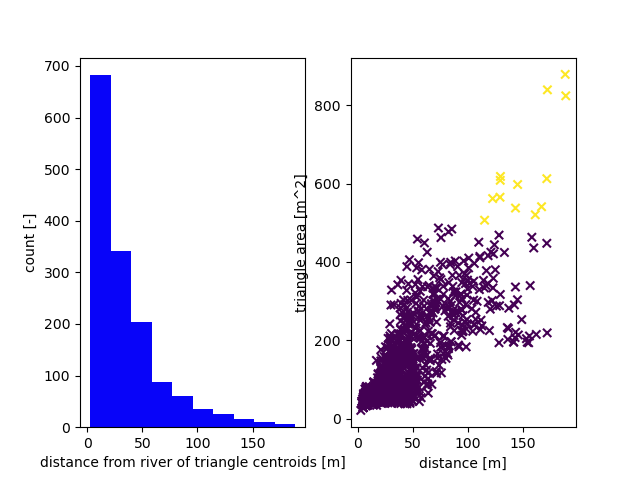

In [12]:
## Triangulation
refine_d0 = 12
refine_d1 = 18
refine_A0 = 82
refine_A1 = 500
d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width) or integer
widths = 5.0

# created two versions of the discrete watershed and rivers -- let's use the second one
watershed, rivers = createCopy(watershed2, rivers2)

#info = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths, diagnostics=True)

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              tol=0.1, diagnostics=True)

In [13]:
# provide elevations to each point of the mesh (in the real case this would come from DEMs)
points3 = np.zeros((len(mesh_points2), 3))
points3[:,:2] = mesh_points2

# apply an elevation gradient downward towards the outlet 
points3[:,2] = 9 + abs(mesh_points2[:,0] - 200) / 800 + mesh_points2[:,1] / 500 

In [14]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(points3.copy(), conn_list)

<Axes: >

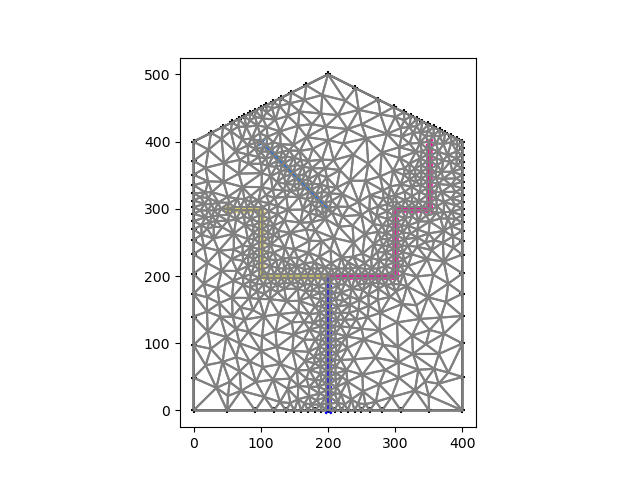

In [15]:
# plot the mesh
fig, ax = plt.subplots(1,1)
plot(watershed, rivers, ax=ax)

df_mesh = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon(m2.coords[c, :]) for c in m2.conn])
df_mesh.boundary.plot(ax=ax, color='grey')
        



In [16]:
# depress the river corridor to burn in streams
def conditionRiverMesh(m2, river, depress_by):
    m2_copy = copy.deepcopy(m2)
    for reach in river:
        for i, elem in enumerate(reach['elems']):
            for j in range(len(elem)):
                m2.coords[elem[j]][2] = m2_copy.coords[elem[j]][2] - depress_by

for river in rivers:
    conditionRiverMesh(m2, river, 1)

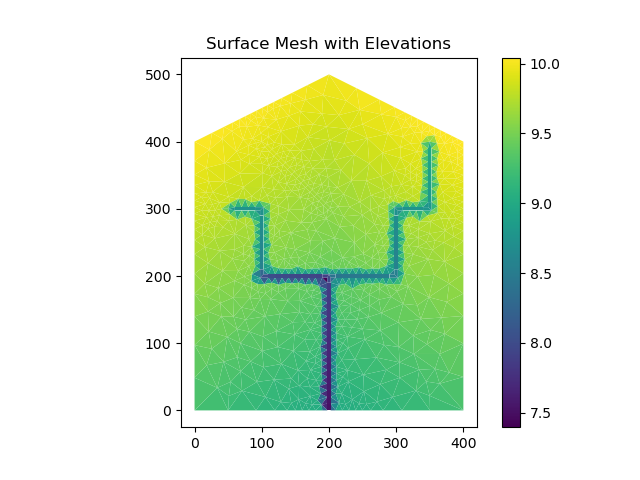

In [17]:
# plotting surface mesh with elevations
fig, ax = plt.subplots(1,1)
watershed_workflow.plot.mesh(m2, ax=ax, 
                        linewidth=0.8, color='elevation', legend=True)

plt.title('Surface Mesh with Elevations')
plt.show()

### Mesh Extrusion

In [18]:
## **** Creating a 3D mesh

# this is oversimplified case where we wille xtrude this mesh in 3D with 10 layers of prescribed thicknesses

total_thickness = 10
dzs=[0.1,0.2, 0.2, 0.25,0.25,0.25,0.25,1,1.25,1.25,2,3]
print(sum(dzs))
assert(sum(dzs)==total_thickness)

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

depth = 0
for dz in dzs:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1000)
  
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2024-12-13 17:55:23,498 - root - INFO: Cell summary:
2024-12-13 17:55:23,498 - root - INFO: ------------------------------------------------------------
2024-12-13 17:55:23,498 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2024-12-13 17:55:23,499 - root - INFO: ------------------------------------------------------------
2024-12-13 17:55:23,499 - root - INFO:  00 	| 00 	| 1000 	|   0.100000 	|   0.000000
2024-12-13 17:55:23,499 - root - INFO:  01 	| 01 	| 1000 	|   0.200000 	|   0.100000
2024-12-13 17:55:23,499 - root - INFO:  02 	| 02 	| 1000 	|   0.200000 	|   0.300000
2024-12-13 17:55:23,499 - root - INFO:  03 	| 03 	| 1000 	|   0.250000 	|   0.500000
2024-12-13 17:55:23,500 - root - INFO:  04 	| 04 	| 1000 	|   0.250000 	|   0.750000
2024-12-13 17:55:23,500 - root - INFO:  05 	| 05 	| 1000 	|   0.250000 	|   1.000000
2024-12-13 17:55:23,500 - root - INFO:  06 	| 06 	| 1000 	|   0.250000 	|   1.250000
2024-12-13 17:55:23,500 - root - INFO:  07 	| 07 	| 1000 	|   1.000000 	|   1.5

10.0


In [19]:
# # extrude
# m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2,layer_types, layer_data, 
#                                              layer_ncells, layer_mat_ids)

# # saving mesh as exodus file
# m3.write_exodus('demo_mixed_element_mesh.exo')